<a href="https://colab.research.google.com/github/danadascalescu00/ioai-transformer-workshop/blob/main/notebooks/IOAI_Transformer_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformers are one of the most influential architectures in modern deep learning. Since the paper [“Attention Is All You Need”](https://arxiv.org/abs/1706.03762) (Vaswani et al., 2017), the Transformer has transformed the way we solve natural language processing tasks — ranging from machine translation to question answering — and has also made a strong impact in computer vision and other fields.

In this session, we'll explore how Transformers work and how they're used in practice. You won't need to build a Transformer from scratch—but we'll walk through a **simplified version** of the architecture using PyTorch's `nn.Transformer` [module](https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html) to help you understand the key components: tokenization, embeddings, positional encodings, attention mechanisms, and more.

Later, we'll move on to using real pretrained Transformer models with the 🤗 **Hugging Face Transformers** library. This ecosystem provides thousands of pretrained models along with tokenizers and ready-to-use pipelines for tasks like text classification, summarization, translation, and more.

The goals for this workshop are to:


*   Understand the structure of Transformer models through code and examples.
*   Use pretrained models for real-world tasks.
*   Learn how to modify and experiment with these models.

The notebook is designed as a self-paced learning tool. Each section includes explanations, runnable code, and short exercises.

## Section 1: Transformer Architecture Deep Dive

### Section 1.1: Environment Setup and Imports

In [ ]:
!pip install transformers torch torchvision torchaudio --quiet
!pip install datasets tokenizers --quiet
!pip install matplotlib seaborn plotly --quiet
!pip install sentence-transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.1 MB/s eta 0:00:00


In [ ]:
from transformers import utils

utils.logging.set_verbosity_error()  # Suppress standard warnings

### Section 1.2: Theory Recap: Transformers in a Nutshell

### Section 1.3: Attention and Self-Attention

#### What is Attention?

**Attention** is a mechanism that allows a model to **focus on the most relevant parts of its input** when producing some output. Just like you might pay more attention to certain words in a sentence when trying to understand its meaning, an AI model uses attention to weigh the importance of different input elements. This idea was inspired by *how humans naturally concentrate on salient information and ignore what's not important at the moment* (*IBM, 2023*).

**Intuitive Analogy:** When you read to answer a question, your eyes jump to the relevant phrases—not every word. Attention does the same: at each step, it weighs input tokens and focuses on those best aligned to produce the next output.

This idea was first introduced by [Bahdanau et al. (2014)](https://arxiv.org/abs/1706.03762) to improve machine translation. Instead of compressing the entire input sentence into one summary vector (as earlier models did), their attention mechanism let the model dynamically “look back” at specific input words during each step of translation—leading to better, more accurate outputs.

#### From Intuition to Vectors: How Attention Works

Let's formalize that a little. In deep learning, we often represent our data as vectors. Say we have:

- A **query** vector **Q** (representing what we want to find or focus on).
- A set of **key** vectors **K** = {K₁, K₂, ..., Kₙ} that label or index the information available.
- A set of **value** vectors **V** = {V₁, V₂, ..., Vₙ} containing the actual information corresponding to each key.

The attention mechanism will score each key **Kᵢ** based on how well it matches the query **Q**. This is done by a **score function**, $f_{attn}$, which is typically a dot product between **Q** and **Kᵢ**  – essentially measuring how aligned these two vectors are. We get a raw score for each key:
$$score_{i} = Q \cdot K_{i}$$


**Scaled Dot-Product Attention:** In modern transformers, the dot-product scores are scaled by the square root of the key dimension, $\sqrt{d_k}$. This prevents the score from growing too large as the vector size increases. After scaling, we apply  a softmax to turn these scores into a probability distribution (weights that sum to 1):

$$ \alpha_i = \frac{exp(\frac{score_i}{\sqrt{d_k}})}{\sum^{n}_{j=1} exp(\frac{score_j}{\sqrt{d_k}})} \: .$$

Here $\alpha_i$ is the attention weight for the $i^{th}$ key. Keys that are more relvant to the query (higher dot product) get higher weights after softmax.

Finally, the output of attention is computed as a weighted sum of values
$$ Attention(Q, K, V) = \sum^{m}_{i=1} α_i V_i \: \: .$$

In matrix form (considering a batch of querires at once for efficiency), we often write as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^{T}}{\sqrt{d_k}}\right) V \: \: ,
$$

which is exactly the formula from the original Transformer paper (*Attention Is All You Need*, Vaswani et al., 2017).

**Key points:** The softmax ensures all weights $\alpha_i$ are between $0$ and $1$ and sum to $1$ (so the output is a convex combination of the values). If one key is a much better match to the query than others, it will get a high weight (close to $1$) and dominate the sum – meaning the output will be close to that key's value vector. If multiple keys are somewhat relevant, the output will be a blend of their values.

> 📖 Note: The terms "query", "*key*", and "*value*" might sound abstract. You can think of it like a dictionary lookup: you have a query (the word you're looking up), keys (the words in the dictionary), and values (the definitions). The attention mechanism finds which dictionary entry (key) is closest to your query and returns the corresponding definition (value), or a mix of definitions if there are multiple pertinent entries.

Before we move on, let's solidify the basic attention idea with a quick example.

#### Example: Calculating Attention Weights (Toy Example)

Suppose we have a single query vector $Q$ and four key vectors $K_{1}...K_{4}$. We'll assign some simple values to these for illustration. We'll also have value vectors $V_{1}...V_{4}$ (for simplicity, let's use the same vectors as keys in this toy example, so we can interpret the output easily).

In [ ]:
import torch
import torch.nn.functional as F

# Create toy data

# Define a single query vector Q (length 3 for example)
Q = torch.tensor([1.0, 0.0, 0.0])  # Query

# Define 4 key vectors K1..K4 (each length 3)
K = torch.tensor([
    [1.0, 0.0, 0.0],   # K1
    [0.0, 1.0, 0.0],   # K2
    [0.0, 0.0, 1.0],   # K3
    [0.5, 0.0, 0.0]    # K4
])

# Define value vectors V1..V4 (also length 3 each, here we set V = K for simplicity)
V = K.clone()

# 1. Compute similarity scores between Q and each K (dot product here)
scores = (K * Q).sum(dim=1)
print("Scores (Q·K):", scores)

# 2. (Optional scaling step — important for larger dimensions, but we skip it here for clarity)
#    In practice, the dot product is scaled by 1/sqrt(d_k) to keep values stable.
#    Typically, d_k = d_model / num_heads (e.g., d_model=512 and 8 heads → d_k=64).
#    Our toy example uses d_k=3, so scaling isn’t critical here.
# scores = scores / math.sqrt(3)

# 3. Apply softmax to get attention weights
weights = F.softmax(scores, dim=0)
print("Attention weights (softmax):", weights)

# 4. Compute the weighted sum of value vectors
# We multiply each value by its weight and sum up
output = (weights.unsqueeze(1) * V).sum(dim=0)
print("Attention output:", output)

Scores (Q·K): tensor([1.0000, 0.0000, 0.0000, 0.5000])
Attention weights (softmax): tensor([0.4269, 0.1571, 0.1571, 0.2589])
Attention output: tensor([0.5564, 0.1571, 0.1571])


🔍 **Let's break down what this means:**

*   The query $Q$ was `[1, 0, 0]`. It has a high dot-product with
$K_1$ (`[1, 0, 0] → 1.0`), a lower score with $K_4$ `([0.5, 0, 0] → 0.5`), and zero with $K_2$ and $K_3$ (since $Q$ has $0s$ in those dimensions). So $Q$ is most similar to $K_1$.

*   After softmax, the attention weights on $K_1$ is the highest (\~$0.43$), $K_4$ is next (\~$0.26$), and $K_2$, $K_3$ have lower weights (\~$0.16$ each).

*   Because we set V = K in this toy example, the attention output is:

  ```output ≈ 0.427 * K1 + 0.157 * K2 + 0.157 * K3 + 0.259 * K4 ≈ [0.556, 0.157, 0.157]```

*   **Interpretation:** The output is heavily influenced by $K_1$ (`[1, 0, 0]`) and somewhat by $K_4$ (`[0.5, 0, 0]`), which both align with $Q$'s first component. The result `[~0.56, ~0.16, ~0.16]` reflects this—most of the attention is focused on the first dimension, just like a human focusing on the most relevant part of the input.


This simple example shows how attention picks out the elements relevant to the query and combines their values. In real models, of course, these vectors and weights are learned, not set manually, and the queries/keys/values could be higher-dimensional. But the procedure is exactly as above.

> 🔧 **Try it yourself:** Change the values of $Q$, $K$, and $V$ in the above code (for example, make $Q$ have a component in the direction of $K_3$, or change the values to see how the output shifts). This will help you see how the attention weights adjust when the query changes or when different keys are present.


Now that we understand the basic idea of attention, let's look at self-attention, which is the attention mechanism used within Transformer models.

#### What is Self-Attention?

**Self-attention** is the mechanism where a set of vectors attends to itself – in other words, *each element in the sequence considers the other elements in the sequence when forming its new representation*. In a Transformer, each word (or token) in a sentence looks at other words in the sentence to decide which ones are important to understanding its meaning. This allows the model to capture **global dependencies** in the input by allowing every position to directly attend to every other position.

How do we get **queries, keys and values** for self-attention?

Recall that, in general, attention (as seen in our toy example or in an encoder-decoder setup), the query may originate from a different source (e.g., the decoder's current state) and retrieve keys/values from the input sequence. In *self-attention*, all three come from the **same sequence** (hence "self").

If we denote our sequence (of embeddings from the previous layer) as a matrix $X$ (shape `[seq_len, d_model]` for one sentence or `[batch, seq_len, d_model]` for a batch), then we simply learn three weight matrices $W^{Q}, W^{K}, W^{V}$  (each of shape `[d_model, d_k]`, `[d_model, d_k]`, `[d_model, d_v]` respectively). We compute:

$$ Q = X W^{Q}, \: \: \: K = X W^{K}, \: \: \: V = X W^{V} \; .$$

Here $Q, K, V$ are all `[seq_len, d_*]` (they have the same sequence length as $X$). Now we apply the same attention formula as before:

$$SelfAttention(X) = softmaxx \left( \frac{QK^{T}}{\sqrt{d_k}} \right) V \:,$$

except that this is done in a way that each position in the sequence is the "query" attending to all keys (including itself). If we look at the $i^{th}$ row of that softmax result, it gives the weights that the $i^{th}$ token places on each token $(1...n)$ in the sequence when gathering values.

#### Introducing the term Multi-Head Attention

In the Transformer (and most modern models), self-attention isn't performed with just one set of $Q, K, \text{and } V$ weights. Instead, it uses **multiple attention heads** in parallel. Each head is an independent self-attention mechanism with its own $W^{Q}, W^{K}, W^{V}$ (usually we set each head to have smaller dimension, so that the total computation is comparable to a single-head of full dimension). If we have, say, $8$ heads, we split the model's embedding dimension into $8$ subspaces (each of size $d_k = d_{\text{model}} / 8 $). Each head focuses on the sequence in a different representation subspace.

Why multiple heads? Because each head can learn to capture **different patterns or relationships** in the data.  For example, one head might specialize in syntax (e.g., matching pronouns to nouns), another in semantic relatedness, another in positional patterns (like attending to the next word), and so on. By having multiple heads, the model can **attend to different things at once** and then combine that information. This was a key insight of the Transformer paper: instead of one monolithic attention, use several in parallel and concatenate their outputs.

The Transformer paper uses the term "**Multi-Head Attention**", where the outputs of each head are concatenated and then passed through a final linear layer (often noted $W^{O}$) to mix the heads together.

#### Implementing Multi-Head Self-Attention (from scratch)

We'll create a PyTorch [`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html
) that performs multi-head attention. For simplicity, we'll assume self-attention (so the same input is used to generate Q, K, and V). This implementation is meant for ilustrative purpose — it may not be as optimized as PyTorch's built-in [`nn.MultiheadAttention`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html), but it's much easier to follow step by step.

In [ ]:
import math
import torch
import torch.nn as nn


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # dimension per head

        # Learnable projection matrices for Q, K, V (we'll use Linear layers for each)
        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)
        # Final linear layer to combine heads
        self.W_O = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        """
        Compute multi-head self-attention on input x.
        x shape: [batch_size, seq_len, embed_dim]
        """
        batch_size, seq_len, _ = x.size()

        # 1. Linear projections to get query, key, value matrices
        Q = self.W_Q(x)  # shape [batch, seq_len, embed_dim]
        K = self.W_K(x)  # shape [batch, seq_len, embed_dim]
        V = self.W_V(x)  # shape [batch, seq_len, embed_dim]

        # 2. Reshape into heads: split embed_dim into (num_heads, head_dim)
        # After reshape: [batch, seq_len, num_heads, head_dim]
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # Permute to shape [batch, num_heads, seq_len, head_dim]
        Q = Q.permute(0, 2, 1, 3)
        K = K.permute(0, 2, 1, 3)
        V = V.permute(0, 2, 1, 3)

        # 3. Calculate attention scores for each head: Q * K^T (scaled)
        # Q has shape [batch, num_heads, seq_len, head_dim]
        # K has shape [batch, num_heads, seq_len, head_dim]
        # We want scores of shape [batch, num_heads, seq_len, seq_len]
        # We achieve that by doing a matmul between Q and K^T for each head.
        scores = torch.matmul(Q, K.transpose(-2, -1))  # dot product over head_dim
        scores = scores / math.sqrt(self.head_dim)     # scale by sqrt(d_k)

        # 4. Softmax to get attention weights
        att_weights = torch.softmax(scores, dim=-1)    # shape [batch, num_heads, seq_len, seq_len]

        # 5. Use attention weights to mix values
        att_output = torch.matmul(att_weights, V)      # shape [batch, num_heads, seq_len, head_dim]

        # 6. Concatenate heads back together
        # att_output currently [batch, num_heads, seq_len, head_dim]
        att_output = att_output.permute(0, 2, 1, 3).contiguous()  # [batch, seq_len, num_heads, head_dim]
        att_output = att_output.view(batch_size, seq_len, self.embed_dim)  # [batch, seq_len, embed_dim]

        # 7. Final linear projection
        output = self.W_O(att_output)  # [batch, seq_len, embed_dim]
        return output, att_weights


Let's test this module with a small random input to ensure it runs and produces sensible shapes:


In [ ]:
# Testing our MultiHeadAttention module
torch.manual_seed(42)
batch_size = 2
seq_len = 5
embed_dim = 8
num_heads = 2

mha = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads)
print(mha)

# Create a random input (batch of 2 sequences, each of length 5, embedding size 8)
x = torch.randn(batch_size, seq_len, embed_dim)
output, att_weights = mha(x)

print("Output shape:", output.shape)           # Expect [2, 5, 8]
print("Attention weights shape:", att_weights.shape)  # Expect [2, 2, 5, 5] -> [batch, heads, Q_len, K_len]
print("Sample attention weights for head 0 of first sequence:\n", att_weights[0, 0])

MultiHeadAttention(
  (W_Q): Linear(in_features=8, out_features=8, bias=True)
  (W_K): Linear(in_features=8, out_features=8, bias=True)
  (W_V): Linear(in_features=8, out_features=8, bias=True)
  (W_O): Linear(in_features=8, out_features=8, bias=True)
)
Output shape: torch.Size([2, 5, 8])
Attention weights shape: torch.Size([2, 2, 5, 5])
Sample attention weights for head 0 of first sequence:
 tensor([[0.1798, 0.1607, 0.2771, 0.1643, 0.2181],
        [0.1640, 0.1430, 0.2019, 0.2457, 0.2453],
        [0.1713, 0.2343, 0.1975, 0.1740, 0.2228],
        [0.1468, 0.1296, 0.3154, 0.2036, 0.2045],
        [0.1551, 0.1751, 0.2392, 0.2045, 0.2261]], grad_fn=<SelectBackward0>)


Of course, these weights are from an untrained random model, so they don't mean much. But in a trained model, these numbers would reflect learned patterns (like attending strongly to certain relevant tokens).

#### Using Built-in and Pre-trained Components for Vizualitation

Writing our own attention is great for learning, but for actual models we rely on well-tested implementations. PyTorch provides `nn.MultiheadAttention` (which implements the same as above but can be used in a more flexible way, including for cross-attention). We won't dive into that here, but it's good to know it exists for when you implement custom models.

We'll also use a library called [**BertViz**](https://github.com/jessevig/bertviz) for visualizing attention in an interactive way.

Now, let's load a pre-trained BERT model and its  tokenizer:

In [ ]:
from transformers import BertModel, BertTokenizer

model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)

sentence = "The cat didn't cross the street because it was too wide."
inputs = tokenizer(sentence, return_tensors='pt')
outputs = model(**inputs)

# The model outputs a tuple: (last_hidden_state, pooler_output, attentions)
attentions = outputs.attentions  # This is a tuple of attention matrices for each layer
print(f"Number of layers: {len(attentions)}")
print(f"Attention matrix shape (layer 1): {attentions[0].shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Number of layers: 12
Attention matrix shape (layer 1): torch.Size([1, 12, 16, 16])


When you run this, BERT will download (the first time) and then you'll see:

*   BERT has $12$ layers, so `len(attentions)` should be $12$ (for BERT-base).
*   Each `attentions[layer]` is a tensor of shape `[batch_size, num_heads, seq_len, seq_len]`. In our case, $batch\_size=1$ (we passed one sentence). BERT-base has $12$ heads. `seq_len` will be the length of the tokenized sequence (including special tokens like `[CLS]`, `[SEP]`).






Now we have the attention weights from a real model for our sentence. How to interpret this? We could manually parse which token is which and see the weights, but it's easier to visualize it.

##### Vizualization with Heatmaps

Tokens: ['[CLS]', 'The', 'cat', 'didn', "'", 't', 'cross', 'the', 'street', 'because', 'it', 'was', 'too', 'wide', '.', '[SEP]']



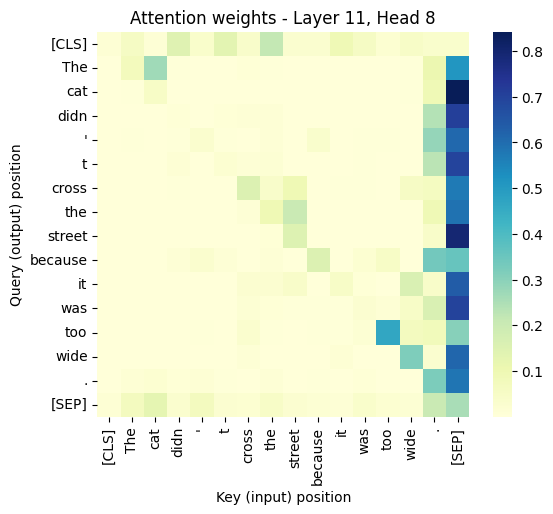

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Get tokens back from input IDs for labeling
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print(f"Tokens: {tokens}\n")

# Choose a layer and head to visualize
layer_index = 10   # penultimate layer
head_index = 7     # last head

# Extract the attention matrix for this layer & head (shape [seq_len, seq_len])
attn_matrix = attentions[layer_index][0, head_index].detach().numpy()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(attn_matrix, annot=False, cmap="YlGnBu", xticklabels=tokens, yticklabels=tokens)
plt.title(f"Attention weights - Layer {layer_index+1}, Head {head_index+1}")
plt.xlabel("Key (input) position")
plt.ylabel("Query (output) position")
plt.show()


This will output a heatmap matrix. The rows represent the query token and columns the key token. Because we're looking at self-attention in the last layer of BERT, "Query (output) position" and "Key (input) position" both correspond to positions in the **same input sentence**.

Each cell intensity shows how much the row word attends to the column word. You might observe some interesting patterns. In this example, from the sentence "*The cat didn't cross the street because it was too wide*", you can spot some interesting patterns:

*   The token "**wide**" receives strong attention from "**it**", suggesting that the model understands "**wide**" as a descriptor linked to the pronoun "**it**", which in turn also attends to "**street**" — capturing the coreference between "**it**" and "**street**".

*   The token "**cross**" attends to "**street**", reinforcing the syntactic and semantic connection between action and location.

*   As is common in deeper layers, the special token `[SEP]` gathers widespread attention, likely reflecting sentence-level summarization behavior.

Keep in mind each head can behave differently, and higher layers often capture more semantic relations. It's worth experimenting with different `layer_index` and `head_index` that might capture other patterns like syntax, position or topic flow.

> 🔍 **Exercise:** Try changing the sentence slightly. See if you can spot a difference in the attention patterns for "it" between the "tired" vs "wide" versions of the sentence. This can hint at the model capturing the change in meaning.

##### Interactive Visualization with BertViz

In [ ]:
!pip install transformers bertviz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.2 MB/s eta 0:00:00


Static heatmaps are useful, but we can do better. The **BertViz** [library](https://github.com/jessevig/bertviz) provides interactive visualizations that let us inspect attention heads in detail. Now that we've installed it, let's use its head view or model view to explore BERT's attention.

The **head view** shows one (or a few) attention heads at a time, drawing lines from each query word to the words it attends to (thickness or color indicates weight). The **model view** gives an overview of all heads in all layers (which can be a lot, but you can focus on one layer at a time).

The **head view** shows one (or a few) attention heads at a time, drawing lines from each query word to the words it attends to (thickness or color indicates weight). The **model view** gives an overview of all heads in all layers (which can be a lot, but you can focus on one layer at a time).

In [ ]:
from bertviz import model_view, head_view

model_view(attentions, tokens)

<IPython.core.display.Javascript object>

If you want to narrow down to a specific layer's heads in BertViz, you could use the `head_view`. For instance:

In [ ]:
head_view(attentions, tokens)

<IPython.core.display.Javascript object>

## Section 3. Embeddings & Weight Manipulation

### Task: Fixing a "Broken BERT" for Sentiment Analysis

***Problem Statement:*** You are given a BERT-based model with corrupted embeddings. Your task is to fix the corrupted embeddings without using other models, additional training data, or fine-tuning. The corruption affects random tokens and may include noise scaling or systematic biases. Our goal is to **repair the corrupted embeddings** *without* retraining the model, using no new external data or extra models.

**Key points of the task:**

*   We have a pre-trained BERT model whose embedding matrix has some **broken vectors** (rows corresponding to specific tokens are corrupted). This severely degrades its downstream performance (sentiment analysis in this case).

*   **No external data or re-training is allowed**. We can't simply fine-tune on a corpus or fetch a fresh embedding from another model. The challenge is to fix the embeddings in using math/logic.

*   We do *know* the model's original weights (except the corrupted parts) and we assume knowledge of which tokens are broken (in a real scenario one might have to detect them, but for this exercise we'll assume the corrupted indices are known in order to focus on repair strategies).

🧩 **Step 1: Load BERT and Extract Embeddings**

In [ ]:
from transformers import BertModel, BertTokenizer
import torch


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = model.embeddings.word_embeddings.weight.detach().clone()  # (vocab_size, hidden_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

🧪 **Step 2: Simulating Embedding Corruption**

Corruption types we'll apply:
*   **Gaussian noise** – add random noise to an embedding vector (simulates a subtle scramble of a token’s values).

*  **Scaling error** – multiply an embedding by a constant factor (simulates a gain glitch; if factor = 0, this is like the vector was nulled out; if factor is negative, the vector’s direction flips).

*   **Additive bias** – add a constant offset to an embedding (simulates a systematic shift in the vector’s values).

In [ ]:
import random


def corrupt_embeddings(
        embeddings: torch.Tensor,
        corruption_ratio: float = 0.2,
        corruption_type: str = "gaussian",
        seed: int = 21
) -> tuple[torch.Tensor, list[int]]:
    torch.manual_seed(seed)
    random.seed(seed)

    corrupted = embeddings.clone()
    vocab_size = embeddings.size(0)

    num_corrupted = int(corruption_ratio * vocab_size)
    corrupted_indices = random.sample(range(vocab_size), num_corrupted)

    for idx in corrupted_indices:
        if corruption_type == "gaussian":
            corrupted[idx] += torch.randn_like(corrupted[idx]) * 0.5
        elif corruption_type == "scaling":
            corrupted[idx] *= torch.tensor(0.3)
        elif corruption_type == "bias":
            corrupted[idx] += 5.0
    return corrupted, corrupted_indices


corrupted_embeddings, corrupted_ids = corrupt_embeddings(embedding_matrix, 0.2, "gaussian")
# Sanity check
print(f"Corrupted {len(corrupted_ids)} out of {embedding_matrix.shape[0]} tokens.")

Corrupted 6104 out of 30522 tokens.


In [ ]:
corrupted_embeddings

tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]])

In [ ]:
embedding_matrix

tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
        [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
        [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
        ...,
        [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
        [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
        [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]])

Now, let's quantify how far off the corrupted embeddings are from the originals:

*   **Cosine similarity** is a good measure of whether a vector's direction has changed. We'll compute cosine similarity between each original embedding and its corrupted version.

*   We'll also keep an eye on vector norms (lengths), because a scaling corruption won't show up as a cosine change (scaling a vector by +3 doesn't alter its direction, only its magnitude).

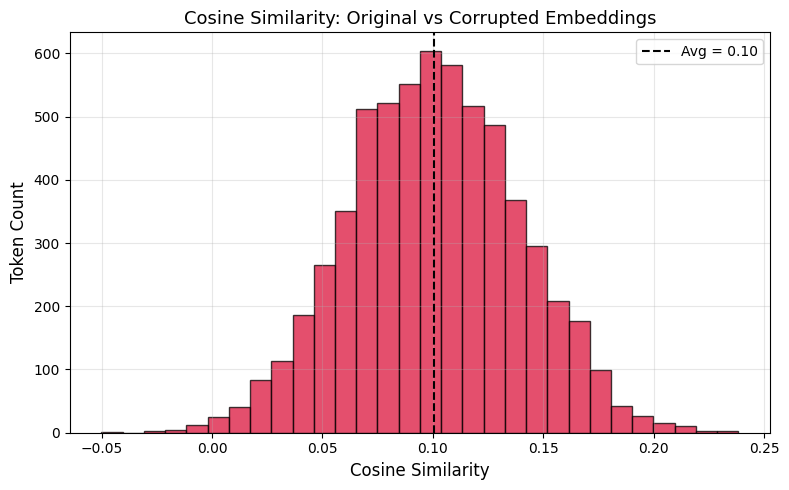

🔎 Average cosine similarity on corrupted tokens: 0.1006


In [ ]:
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity

def plot_cosine_similarity_distribution(original_embeds, corrupted_embeds, corrupted_ids):
    """
    Plot histogram of cosine similarities between original and corrupted embeddings.
    """
    similarities = [
        cosine_similarity(original_embeds[idx].unsqueeze(0), corrupted_embeds[idx].unsqueeze(0)).item()
        for idx in corrupted_ids
    ]

    avg_sim = sum(similarities) / len(similarities)

    plt.figure(figsize=(8, 5))
    plt.hist(similarities, bins=30, color='crimson', alpha=0.75, edgecolor='black')
    plt.axvline(avg_sim, color='black', linestyle='--', label=f'Avg = {avg_sim:.2f}')
    plt.title("Cosine Similarity: Original vs Corrupted Embeddings", fontsize=13)
    plt.xlabel("Cosine Similarity", fontsize=12)
    plt.ylabel("Token Count", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"🔎 Average cosine similarity on corrupted tokens: {avg_sim:.4f}")



plot_cosine_similarity_distribution(embedding_matrix, corrupted_embeddings, corrupted_ids)


Another way to visualize the damage is to project the high-dimensional embeddings down to 2D (using PCA for dimensionality reduction) and see where the corrupted vectors lie relative to the original cluster of embeddings:

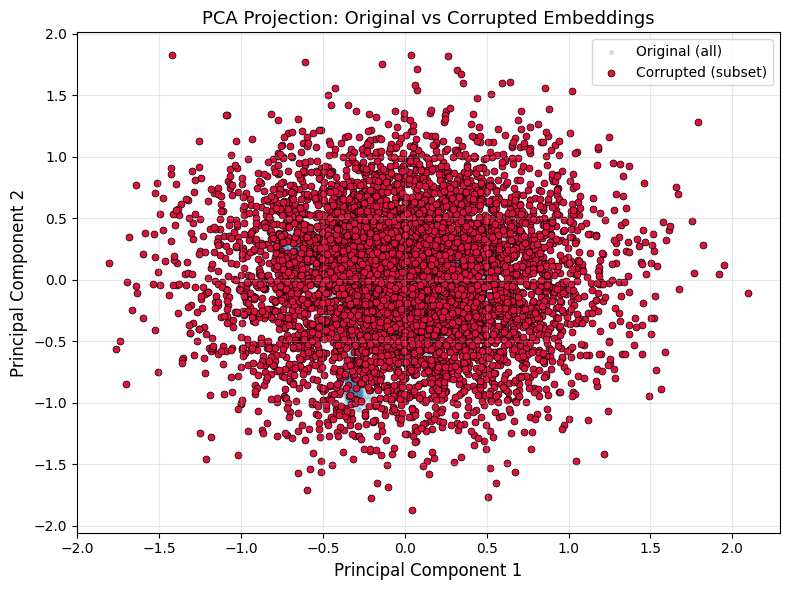

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def plot_pca_embedding_projection(original_embeds, corrupted_embeds, corrupted_ids, n_components=2):
    """
    Plot a 2D PCA projection of the original and corrupted embeddings.
    """
    pca = PCA(n_components=n_components)

    # Project both original and corrupted embeddings
    original_np = original_embeds.cpu().numpy()
    corrupted_np = corrupted_embeds.cpu().numpy()

    pca.fit(original_np)
    proj_original = pca.transform(original_np)
    proj_corrupted = pca.transform(corrupted_np)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(proj_original[:, 0], proj_original[:, 1], alpha=0.2, label="Original (all)", s=8, color='steelblue')
    plt.scatter(
        proj_corrupted[corrupted_ids, 0],
        proj_corrupted[corrupted_ids, 1],
        color="crimson",
        label="Corrupted (subset)",
        edgecolor='black',
        linewidth=0.5,
        s=25
    )

    plt.title("PCA Projection: Original vs Corrupted Embeddings", fontsize=13)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



plot_pca_embedding_projection(embedding_matrix, corrupted_embeddings, corrupted_ids)


### Comparison of Cosine Similarity and PCA Visualization for Embedding Analysis

| **Aspect**                                     | **Cosine Similarity**                                                                                                                                         | **PCA Visualization**                                                                                                                                     |
| ---------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **What it Measures**                           | Measures the cosine of the angle between two vectors. Focuses on the direction of vectors, not their magnitude.                                               | Projects high-dimensional data into a lower-dimensional space (typically 2D or 3D) based on directions of maximum variance.                               |
| **Sensitivity to Magnitude Changes**           | Not sensitive. A scaled version of a vector (e.g., multiplied by 0.5 or 5.0) will still have the same direction, resulting in a cosine similarity close to 1. | Sensitive. Any change in magnitude can affect the variance captured by PCA, potentially changing the position of points in the projected space.           |
| **Sensitivity to Direction Changes**           | Highly sensitive. A small change in vector direction can significantly reduce cosine similarity.                                                              | Sensitive as well, but direction changes are visualized in terms of relative placement, not quantified explicitly.                                        |
| **Granularity**                                | Provides a per-token numerical value that quantifies the similarity between the original and corrupted version.                                               | Provides a global visual representation of how the entire set of embeddings shifts or clusters. Not suitable for precise token-level measurement.         |
| **Interpretability**                           | Direct: values close to 1 indicate similar vectors, while values closer to 0 (or negative) indicate dissimilarity.                                            | Visual: useful for detecting outliers, observing shifts in distribution, or understanding general patterns, but not quantitatively precise.               |
| **Usefulness for Embedding Repair Evaluation** | Useful for measuring how much each individual corrupted embedding differs from its original. Appropriate for statistical reporting.                           | Useful for diagnosing whether corruption is isolated or affects broader regions of the embedding space. Good for qualitative comparisons between methods. |
| **Limitations**                                | Ignores magnitude differences; may overestimate similarity when vectors are scaled versions of each other.                                                    | Dimensionality reduction can introduce distortion; the results depend on the data distribution and choice of components.                                  |
| **Best Use Cases**                             | Token-level analysis, repair performance metrics, thresholding for evaluation.                                                                                | Visual inspection of embedding space, debugging repair strategies, detecting structural changes.                                                          |


In [ ]:
from torch.nn.functional import cosine_similarity
import torch


# 1. Pregătește propoziția
sentence = "It was a great movie!"
input_ids = tokenizer.encode(sentence, return_tensors="pt")
token_ids = input_ids[0]
token_strs = tokenizer.convert_ids_to_tokens(token_ids)

# 2. Obține embedding-urile originale
original_embeds = model.embeddings.word_embeddings(input_ids).squeeze(0).detach()

# 3. Înlocuiește embedding-urile din model cu cele corupte
original_backup = model.embeddings.word_embeddings.weight.data.clone()  # backup în caz că vrei să revii
model.embeddings.word_embeddings.weight.data = corrupted_embeddings

# 4. Obține embedding-urile corupte pentru aceiași tokeni
corrupted_embeds = model.embeddings.word_embeddings(input_ids).squeeze(0).detach()

# 5. Evaluează diferențele
print(f"{'Token':<12} {'Cosine Sim (original vs corrupted)':>40}")
print("-" * 55)
for i, token in enumerate(token_strs):
    sim = cosine_similarity(original_embeds[i].unsqueeze(0), corrupted_embeds[i].unsqueeze(0)).item()
    mark = " <-- CORRUPT" if token_ids[i].item() in corrupted_ids else ""
    print(f"{token:<12} {sim:>40.4f}{mark}")

Token              Cosine Sim (original vs corrupted)
-------------------------------------------------------
[CLS]                                          0.1294 <-- CORRUPT
it                                             1.0000
was                                            1.0000
a                                              1.0000
great                                          0.0793 <-- CORRUPT
movie                                          1.0000
!                                              1.0000
[SEP]                                          1.0000


🛠️ **Step 3: Repair Strategies**

**Strategy 1 (Simple Baseline): Mean Embedding Replacement**

In [ ]:
import torch


def repair_with_mean_embedding(
    corrupted_embeddings: torch.Tensor,
    corrupted_ids: list[int]
) -> torch.Tensor:
    repaired = corrupted_embeddings.clone()
    vocab_size = corrupted_embeddings.size(0)

    uncorrupted_ids = list(set(range(vocab_size)) - set(corrupted_ids))

    # Compute the mean of all uncorrupted embeddings
    mean_embedding = corrupted_embeddings[uncorrupted_ids].mean(dim=0)

    # Replace corrupted tokens with the mean vector
    for idx in corrupted_ids:
        repaired[idx] = mean_embedding

    return repaired

repaired_mean = repair_with_mean_embedding(corrupted_embeddings, corrupted_ids)


In [ ]:
from torch.nn.functional import cosine_similarity

sims_mean = [
    cosine_similarity(embedding_matrix[idx].unsqueeze(0), repaired_mean[idx].unsqueeze(0)).item()
    for idx in corrupted_ids
]


print(f"Mean Repair - Avg cosine similarity (original vs repaired): {sum(sims_mean)/len(sims_mean):.4f}")

Mean Repair - Avg cosine similarity (original vs repaired): 0.6671


Strategy 2: KNN-based embedding repair

**Idea:** Replace each corrupted embedding with the mean of its k nearest neighbor embeddings that are not corrupted. The assumption is that words live in clusters in embedding space; if a word's vector is damaged, the closest intact vectors (by cosine similarity) likely represent words of similar meaning, so averaging them could approximate the original vector

In [ ]:
from sklearn.neighbors import NearestNeighbors
import torch
import numpy as np


def repair_with_knn(
    corrupted_embeddings: torch.Tensor,
    corrupted_ids: list[int],
    k: int = 1
) -> torch.Tensor:

    repaired = corrupted_embeddings.clone()
    vocab_size = corrupted_embeddings.size(0)

    # Identify uncorrupted embeddings
    uncorrupted_ids = list(set(range(vocab_size)) - set(corrupted_ids))

    # Prepare data for KNN
    X_train = corrupted_embeddings[uncorrupted_ids].cpu().numpy()
    X_query = corrupted_embeddings[corrupted_ids].cpu().numpy()

    # Fit KNN with cosine distance
    knn = NearestNeighbors(n_neighbors=k, metric="cosine")
    knn.fit(X_train)
    distances, indices = knn.kneighbors(X_query)

    # Replace each corrupted vector with its k-nearest uncorrupted average
    for i, corrupted_idx in enumerate(corrupted_ids):
        neighbor_ids = [uncorrupted_ids[j] for j in indices[i]]
        mean_vec = corrupted_embeddings[neighbor_ids].mean(dim=0)
        repaired[corrupted_idx] = mean_vec

    return repaired


In [ ]:
def evaluate_knn_repair_over_k(
    embedding_matrix: torch.Tensor,
    corrupted_embeddings: torch.Tensor,
    corrupted_ids: list[int],
    k_values: list[int]
):
    results = {}
    for k in k_values:
        repaired_knn = repair_with_knn(corrupted_embeddings, corrupted_ids, k=k)
        sims_knn = [
            cosine_similarity(embedding_matrix[idx].unsqueeze(0), repaired_knn[idx].unsqueeze(0)).item()
            for idx in corrupted_ids
        ]
        avg_sim = sum(sims_knn) / len(sims_knn)
        results[k] = avg_sim
        print(f"KNN Repair (k={k}) - Avg cosine similarity: {avg_sim:.4f}")

    return results


k_values = [1, 3, 5, 7, 10, 555]
knn_results = evaluate_knn_repair_over_k(embedding_matrix, corrupted_embeddings, corrupted_ids, k_values)


KNN Repair (k=1) - Avg cosine similarity: 0.4239
KNN Repair (k=3) - Avg cosine similarity: 0.5481
KNN Repair (k=5) - Avg cosine similarity: 0.5895
KNN Repair (k=7) - Avg cosine similarity: 0.6100
KNN Repair (k=10) - Avg cosine similarity: 0.6270
KNN Repair (k=555) - Avg cosine similarity: 0.6723


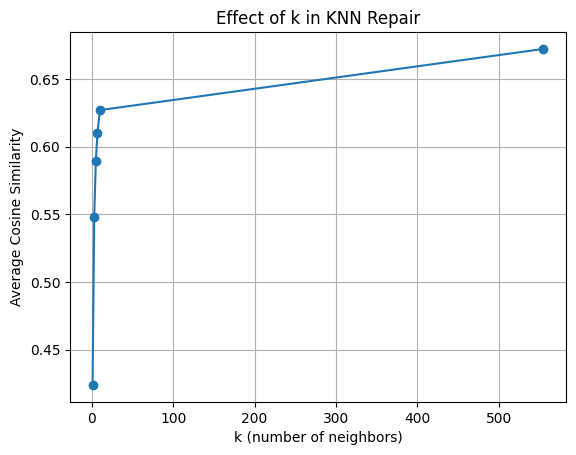

In [ ]:
plt.plot(list(knn_results.keys()), list(knn_results.values()), marker='o')
plt.title("Effect of k in KNN Repair")
plt.xlabel("k (number of neighbors)")
plt.ylabel("Average Cosine Similarity")
plt.grid(True)
plt.show()

In [ ]:
# Repară embedding-urile corupte
repaired_knn = repair_with_knn(corrupted_embeddings, corrupted_ids, k=1)

# Înlocuiește în model
model.embeddings.word_embeddings.weight.data = repaired_knn

In [ ]:
# Calculează din nou similaritățile
sentence = "It was a great movie!"
input_ids = tokenizer.encode(sentence, return_tensors="pt")
token_ids = input_ids[0]
token_strs = tokenizer.convert_ids_to_tokens(token_ids)

original_embeds = embedding_matrix[input_ids].squeeze(0).detach()
repaired_embeds = repaired_knn[input_ids].squeeze(0).detach()

print(f"\n{'Token':<12} {'Cosine Sim (original vs repaired via KNN)':>40}")
print("-" * 55)
for i, token in enumerate(token_strs):
    sim = cosine_similarity(original_embeds[i].unsqueeze(0), repaired_embeds[i].unsqueeze(0)).item()
    mark = " <-- was corrupted" if token_ids[i].item() in corrupted_ids else ""
    print(f"{token:<12} {sim:>40.4f}{mark}")


Token        Cosine Sim (original vs repaired via KNN)
-------------------------------------------------------
[CLS]                                          0.0926 <-- was corrupted
it                                             1.0000
was                                            1.0000
a                                              1.0000
great                                          0.2580 <-- was corrupted
movie                                          1.0000
!                                              1.0000
[SEP]                                          1.0000


**Strategy 3: PCA-Based Dimensionality Reduction and Restoration**

In [ ]:
from sklearn.decomposition import PCA

def repair_with_pca(corrupted_embeddings, corrupted_ids, n_components=128):
    repaired = corrupted_embeddings.clone()

    all_vectors = corrupted_embeddings.cpu().numpy()
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(all_vectors)
    restored = pca.inverse_transform(reduced)

    restored = torch.tensor(restored).to(corrupted_embeddings.device)

    for idx in corrupted_ids:
        repaired[idx] = restored[idx]
    return repaired

In [ ]:
repaired_pca = repair_with_pca(corrupted_embeddings, corrupted_ids, n_components=128)
model.embeddings.word_embeddings.weight.data = repaired_pca

In [ ]:
repaired_embeds = repaired_pca[input_ids].squeeze(0).detach()

print(f"\n{'Token':<12} {'Cosine Sim (original vs repaired via PCA)':>40}")
print("-" * 55)
for i, token in enumerate(token_strs):
    sim = cosine_similarity(original_embeds[i].unsqueeze(0), repaired_embeds[i].unsqueeze(0)).item()
    mark = " <-- was corrupted" if token_ids[i].item() in corrupted_ids else ""
    print(f"{token:<12} {sim:>40.4f}{mark}")


Token        Cosine Sim (original vs repaired via PCA)
-------------------------------------------------------
[CLS]                                          0.1204 <-- was corrupted
it                                             1.0000
was                                            1.0000
a                                              1.0000
great                                          0.1002 <-- was corrupted
movie                                          1.0000
!                                              1.0000
[SEP]                                          1.0000


Strategy 4: Centering and Normalization of Corrupted Vectors

In [ ]:
def repair_with_centering(corrupted_embeddings, corrupted_ids):
    repaired = corrupted_embeddings.clone()

    # Media globală a embedding-urilor
    mean_vector = corrupted_embeddings.mean(dim=0)

    for idx in corrupted_ids:
        vec = corrupted_embeddings[idx]
        centered = vec - mean_vector
        normed = centered / (centered.norm() + 1e-6)
        repaired[idx] = normed
    return repaired

In [ ]:
repaired_center = repair_with_centering(corrupted_embeddings, corrupted_ids)
model.embeddings.word_embeddings.weight.data = repaired_center

In [ ]:
repaired_embeds = repaired_center[input_ids].squeeze(0).detach()

print(f"\n{'Token':<12} {'Cosine Sim (original vs repaired via Centering)':>40}")
print("-" * 55)
for i, token in enumerate(token_strs):
    sim = cosine_similarity(original_embeds[i].unsqueeze(0), repaired_embeds[i].unsqueeze(0)).item()
    mark = " <-- was corrupted" if token_ids[i].item() in corrupted_ids else ""
    print(f"{token:<12} {sim:>40.4f}{mark}")


Token        Cosine Sim (original vs repaired via Centering)
-------------------------------------------------------
[CLS]                                          0.1208 <-- was corrupted
it                                             1.0000
was                                            1.0000
a                                              1.0000
great                                          0.0557 <-- was corrupted
movie                                          1.0000
!                                              1.0000
[SEP]                                          1.0000


**Strategy 5: Synonym-Based Repair using WordNet**

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
import torch

try:
    wn.synsets("dog")
except LookupError:
    nltk.download("wordnet")

def repair_with_wordnet(
    corrupted_embeddings: torch.Tensor,
    corrupted_ids: list[int],
    embedding_matrix: torch.Tensor,
    tokenizer
) -> torch.Tensor:
    repaired = corrupted_embeddings.clone()
    vocab = [tokenizer.convert_ids_to_tokens([i])[0] for i in range(corrupted_embeddings.size(0))]

    for idx in corrupted_ids:
        token = vocab[idx]

        # Collect valid synonym tokens that are also in vocab and not corrupted
        synonyms = set()
        for synset in wn.synsets(token):
            for lemma in synset.lemmas():
                synonym = lemma.name()
                if (
                    synonym != token
                    and "_" not in synonym
                    and synonym in vocab
                ):
                    j = vocab.index(synonym)
                    if j not in corrupted_ids:
                        synonyms.add(synonym)

        if synonyms:
            syn_indices = [vocab.index(w) for w in synonyms]
            syn_vectors = corrupted_embeddings[syn_indices]
            repaired[idx] = syn_vectors.mean(dim=0)

    return repaired


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
repaired_syn = repair_with_wordnet(
    corrupted_embeddings,
    corrupted_ids,
    embedding_matrix,
    tokenizer
)

In [ ]:
sims_syn = [
    cosine_similarity(embedding_matrix[idx].unsqueeze(0), repaired_syn[idx].unsqueeze(0)).item()
    for idx in corrupted_ids
]

print(f"WordNet Synonym Repair - Avg cosine similarity (original vs repaired): {sum(sims_syn)/len(sims_syn):.4f}")

WordNet Synonym Repair - Avg cosine similarity (original vs repaired): 0.3058


In [ ]:
def repair_with_wordnet_pos(
    corrupted_embeddings: torch.Tensor,
    corrupted_ids: list[int],
    embedding_matrix: torch.Tensor,
    tokenizer,
    allowed_pos: set = {"n", "v", "a", "r"}  # n=noun, v=verb, a=adj, r=adv
) -> torch.Tensor:
    repaired = corrupted_embeddings.clone()
    vocab = [tokenizer.convert_ids_to_tokens([i])[0] for i in range(corrupted_embeddings.size(0))]

    for idx in corrupted_ids:
        token = vocab[idx]

        # Only single words
        if token.startswith("##") or "_" in token:
            continue

        synonyms = set()
        for synset in wn.synsets(token):
            if synset.pos() not in allowed_pos:
                continue

            for lemma in synset.lemmas():
                synonym = lemma.name()
                if synonym == token or "_" in synonym:
                    continue
                if synonym in vocab:
                    j = vocab.index(synonym)
                    if j not in corrupted_ids:
                        synonyms.add(synonym)

        if synonyms:
            syn_indices = [vocab.index(w) for w in synonyms]
            syn_vectors = corrupted_embeddings[syn_indices]
            repaired[idx] = syn_vectors.mean(dim=0)

    return repaired


In [ ]:
repaired_syn_pos = repair_with_wordnet_pos(
    corrupted_embeddings,
    corrupted_ids,
    embedding_matrix,
    tokenizer
)

sims_syn_pos = [
    cosine_similarity(embedding_matrix[idx].unsqueeze(0), repaired_syn_pos[idx].unsqueeze(0)).item()
    for idx in corrupted_ids
]
print(f"WordNet Repair w/ POS Filtering (nouns only) - Avg cosine similarity: {sum(sims_syn_pos)/len(sims_syn_pos):.4f}")


WordNet Repair w/ POS Filtering (nouns only) - Avg cosine similarity: 0.2915


Step 4: Evaluate

In [ ]:
def evaluate_similarity(original_embeds, repaired_embeds, token_ids, token_strs, corrupted_ids, label):
    sims = []
    for i, tok_id in enumerate(token_ids):
        sim = cosine_similarity(original_embeds[i].unsqueeze(0), repaired_embeds[i].unsqueeze(0)).item()
        if tok_id.item() in corrupted_ids:
            sims.append((token_strs[i], sim, label))
    return sims

In [ ]:
# Input-uri comune
sentence = "The cat sat on the mat."
input_ids = tokenizer.encode(sentence, return_tensors="pt")
token_ids = input_ids[0]
token_strs = tokenizer.convert_ids_to_tokens(token_ids)
original_embeds = embedding_matrix[input_ids].squeeze(0).detach()

# Repară
rep_knn = repair_with_knn(corrupted_embeddings, corrupted_ids)
rep_pca = repair_with_pca(corrupted_embeddings, corrupted_ids)
rep_center = repair_with_centering(corrupted_embeddings, corrupted_ids)

# Embedding-uri reparate per metodă
emb_knn = rep_knn[input_ids].squeeze(0).detach()
emb_pca = rep_pca[input_ids].squeeze(0).detach()
emb_ctr = rep_center[input_ids].squeeze(0).detach()

# Scoruri cosine similarity doar pentru tokenii corupți
sim_knn = evaluate_similarity(original_embeds, emb_knn, token_ids, token_strs, corrupted_ids, "KNN")
sim_pca = evaluate_similarity(original_embeds, emb_pca, token_ids, token_strs, corrupted_ids, "PCA")
sim_ctr = evaluate_similarity(original_embeds, emb_ctr, token_ids, token_strs, corrupted_ids, "Centering")

# Combina scorurile
all_sims = sim_knn + sim_pca + sim_ctr

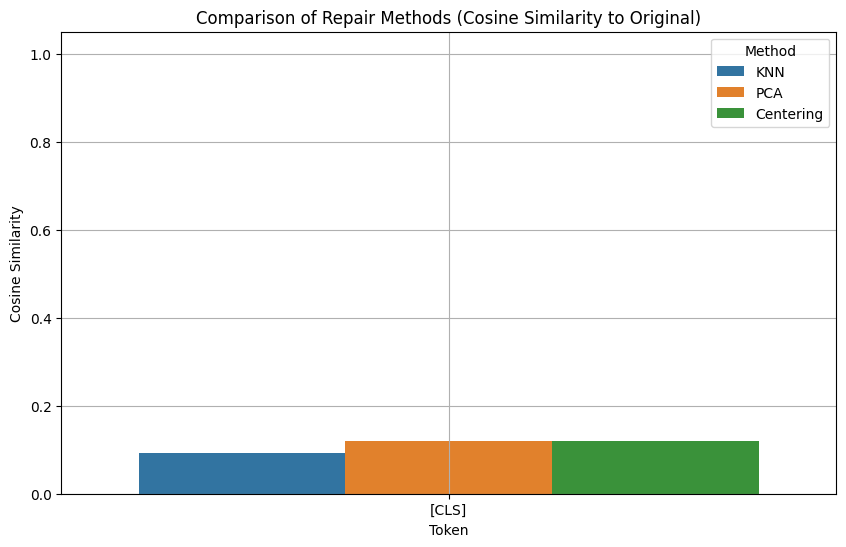

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame(all_sims, columns=["Token", "CosineSim", "Method"])

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Token", y="CosineSim", hue="Method")
plt.ylim(0, 1.05)
plt.title("Comparison of Repair Methods (Cosine Similarity to Original)")
plt.ylabel("Cosine Similarity")
plt.grid(True)
plt.show()

> What if **we do not know which embeddings** are corrupted in the first place? In our analysis we assumed we have a list of affected token indices. How might you **detect anomalous or corrupted embeddings** in a large embedding matrix without ground truth? (Think about statistical signatures, out-of-distribution detection, using the Transformer’s behavior itself, etc.)

Legend:

Young Alex has a beloved BERT model that he carries everywhere on his trusty flash drive. One day, during an excursion along the River Styx, a few drops of water landed on the precious device, corrupting the model's weights.

Heartbroken, Alex rushed home to fix the neural network. After quick analysis, he discovered only the token embeddings were damaged - the rest of the architecture (attention blocks and heads) remained perfectly intact. Now he needs to restore the model's performance on Sentiment Analysis Task.

Task:

You need to fix the broken vectors of the Embeddings matrix of the model so as to improve the quality of the model on the task of text sentiment analysis.

Restrictions:

You can not use any other transformer based pre-trained models and LLMs.

You can not any additional data

You can not fine-tune or pre-train model

In [ ]:
import numpy as np
import pandas as pd
import torch
np.random.seed(21)

In [ ]:
val_data_path = "val_dataset.csv"
test_data_path = "test.csv"

val_df = pd.read_csv(val_data_path)
test_df = pd.read_csv(test_data_path)

FileNotFoundError: [Errno 2] No such file or directory: 'val_dataset.csv'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Ilseyar-kfu/broken_bert")

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
val_encodings = tokenizer(val_df["text"].to_list(), truncation=True, padding=True, max_length=256)
val_dataset = Dataset(val_encodings, val_df["labels"].to_list())

In [ ]:
texts_2_score = val_df["text"].to_list() + test_df["text"].to_list()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("Ilseyar-kfu/broken_bert")

new_embedings = model.bert.embeddings.word_embeddings.weight.detach().numpy().copy()

# There's magic going on here!!! And we get very new !!! new_embedings !!!

model.bert.embeddings.word_embeddings.weight = torch.nn.Parameter(torch.Tensor(new_embedings))

In [ ]:
from sklearn.metrics import f1_score
from numpy import argmax
from transformers import pipeline
import wandb
wandb.init(mode= "disabled")

In [ ]:
from sklearn.metrics import classification_report

def evaluate_on_validation(model, tokenizer, df_val):
    label_2_dict = {'LABEL_0': 'neutral', "LABEL_1" : 'positive', "LABEL_2": 'negative'}
    classifier = pipeline("text-classification", model= model, tokenizer = tokenizer)
    answ = classifier.predict(list(df_val["text"]))
    answ = [label_2_dict[el["label"]] for el in answ]

    # print(f1_score(p.label_ids, preds, average='macro'))
    print(classification_report(df_val["labels"], answ))

In [ ]:
evaluate_on_validation(model, tokenizer, val_df)

Solution

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.optim import AdamW
from tqdm import tqdm

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Ilseyar-kfu/broken_bert")
model = AutoModelForSequenceClassification.from_pretrained("Ilseyar-kfu/broken_bert")

# Freeze all layers except the embeddings
for param in model.parameters():
    param.requires_grad = False

model.bert.embeddings.word_embeddings.weight.requires_grad = True

# Prepare the dataset and dataloader
val_encodings = tokenizer(val_df["text"].to_list(), truncation=True, padding=True, max_length=256)
val_labels = val_df["labels"].to_list()
val_labels = [0 if label == "neutral" else 1 if label == "positive" else 2 for label in val_labels]

val_dataset = Dataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

# Set up the optimizer
optimizer = AdamW([model.bert.embeddings.word_embeddings.weight], lr=1e-4/1.5)

# Set up the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

In [ ]:
from tqdm import tqdm


num_epochs = 31
patience = 3  # Number of epochs to wait for improvement before stopping
best_loss = float('inf')
epochs_no_improve = 0


model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(val_loader)
    print(f"Epoch {epoch+1} - Avg Training Loss: {avg_train_loss:.4f}")

    # Early stopping
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        epochs_no_improve = 0
        # Optional:
        # torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

In [ ]:
evaluate_on_validation(model, tokenizer, val_df)

## Part 4: Cross-Lingual Transfer

### Task: Cross-Lingual Intent Detection & Slot Filling

 Imagine you have a virtual assistant trained to understand Englsh queries, but now you need to handle Romanian inputs without restraining from scratch on Romanian data. When developing AI Assistants, for example, supporting multiple languages is a common requirement, and practitioners often rely on multilingual models. However, in low-resource settings or when training data is limited, it's often necessary to adapt a model trained on English to other languages. A common workaround is to use machine translation as a bridge between languages. While these strategies are common in real-world systems, the NEOAI 2025 challenge places strict constraints that prevent their use.

**Restrictions**

- You are not allowed to translate the dataset.

- You must use only the data provided in the competition; no external data is allowed. Data augmentation is permitted, but only using the training data.

- You cannot change the base model or its architecture.

- You cannot train or fine-tune on the validation or test sets—they are for evaluation only.

- You cannot use any other multilingual transformer-based models, LLMs (e.g., GPT, BERT, GPT-4o, T5), or external APIs, whether open-source or commercial.

1. Import și setup

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch
import random

2. Date simple în engleză cu etichete binare


In [ ]:
train_texts = [
    "What is the problem?",
    "How can I fix this issue?",
    "Please provide more information.",
    "The computer is not working.",
    "Send me the email."
]
train_labels = [1, 1, 0, 1, 0]  # 1 = problem/issue, 0 = no problem/neutral

3. Augmentare simplă

In [ ]:
synonyms = {
    "problem": ["issue", "difficulty", "challenge"],
    "fix": ["resolve", "repair", "correct"],
    "provide": ["give", "offer", "supply"],
    "computer": ["pc", "machine", "device"],
    "email": ["message", "mail"]
}

def augment_english_text(text):
    words = text.lower().split()
    augmented = []
    for w in words:
        key = w.strip('?.!,')
        if key in synonyms and random.random() < 0.5:
            syn = random.choice(synonyms[key])
            augmented.append(syn)
        else:
            augmented.append(w)
    return " ".join(augmented)

Dataset și DataLoader

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=32, return_tensors='pt')
        item = {k: v.squeeze() for k,v in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

Simplu stemmer românesc


In [ ]:
def simple_romanian_stem(word):
    suffixes = ['ul', 'a', 'le', 'i', 'lor', 'lui', 'ea']
    for suffix in suffixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def preprocess_romanian(text):
    tokens = text.lower().replace('?', '').split()
    stemmed = [simple_romanian_stem(t) for t in tokens]
    return " ".join(stemmed)

Pregătire model + tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)

Antrenament rapid

In [ ]:
# Augmentăm datele
augmented_texts = [augment_english_text(t) for t in train_texts]
all_texts = train_texts + augmented_texts
all_labels = train_labels * 2

dataset = SimpleDataset(all_texts, all_labels, tokenizer)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(3):
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {loss.item():.4f}")

 Input român zero-shot

In [ ]:
model.eval()

romanian_input = "Care este problema cu computerul meu?"
preprocessed = preprocess_romanian(romanian_input)
print(f"Romanian input preprocessed: {preprocessed}")

inputs = tokenizer(preprocessed, return_tensors='pt').to(device)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)

print(f"Model output probabilities: {probs.cpu().numpy()}")
predicted_class = probs.argmax().item()
print(f"Predicted class: {predicted_class} ({'problem' if predicted_class == 1 else 'no problem'})")

## 📚  References

- Vaswani et al., 2023 – ["Attention is All You Need"](https://arxiv.org/abs/1706.03762)

 *The original paper introducing the Transformer architecture and self-attention mechanism.*

- Bahdanau et al., 2016 – ["Neural Machine Translation by Jointly Learning to Align and Translate"](https://arxiv.org/abs/1409.0473)

 *Introduced the attention mechanism to improve machine translation performance.*

- IBM, 2023 – [Understanding the Attention Mechanism in AI](https://www.ibm.com/think/topics/attention-mechanism)
  
  *A comprehensive article covering the intuition behind attention, its mathematical formulation, and its implementation in models.*

- Hugging Face – [LLM Course](https://huggingface.co/learn/llm-course/chapter1/1)

 *A beginner-friendly course on large language models and Transformers.*

- UVADLC – [Tutorial 6: Transformers and MH Attention](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html)

 *A hands-on deep dive into Transformer internals, great for implementation guidance.*

- Northern Eurasia OAI 2025 [Kaggle Competition](https://www.kaggle.com/competitions/neoai-2025/overview)

 *The First International AI Olympiad for School Students Across Northern Eurasia*